In [16]:
import json
import tensorflow as tf
from tensorflow.keras import Input
import numpy as np
import pandas as pd
import pickle
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Dense, Concatenate, Dropout, BatchNormalization, LSTM
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping

# Configuring TensorFlow to use GPU
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


#### Datasets

In [17]:
# drugs
drugs = pd.read_csv('../data/drugs.csv', index_col=1)
drugs.drop(['Unnamed: 0'], axis=1, inplace=True)

# cell lines
cell_lines = pd.read_csv('../data/gene_expression.csv', index_col=0)

# combinations
combinations = pd.read_csv('../data/combinations.csv', index_col=0)

In [18]:
# reduce cell lines to the 2128 most important genes

with open('../data/2128_genes.pkl', 'rb') as f:
    top_genes = pickle.load(f)

filtered_cell_lines = cell_lines[cell_lines.columns.intersection(top_genes)]

In [19]:
combinations

,Drug_ID,Cell Line_ID,Y
0,Camptothecin,HCC1954,-0.251083
1,Camptothecin,HCC1143,1.343315
2,Camptothecin,HCC1187,1.736985
3,Camptothecin,HCC1395,-2.309078
4,Camptothecin,HCC1599,-3.106684
...,...,...,...
92698,JQ1,EFM-192A,3.576583
92699,JQ1,HCC1428,1.402466
92700,JQ1,HDQ-P1,2.762460
92701,JQ1,JIMT-1,3.442930


### Merge data

In [20]:
drugs

,Drug
Drug_ID,
Camptothecin,CC[C@@]1(C2=C(COC1=O)C(=O)N3CC4=CC5=CC=CC=C5N=...
Vinblastine,CC[C@@]1(CC2C[C@@](C3=C(CCN(C2)C1)C4=CC=CC=C4N...
Cisplatin,N.N.[Cl-].[Cl-].[Pt+2]
Cytarabine,C1=CN(C(=O)N=C1N)[C@H]2[C@H]([C@@H]([C@H](O2)C...
Docetaxel,CC1=C2[C@H](C(=O)[C@@]3([C@H](C[C@@H]4[C@]([C@...
...,...
LJI308,C1COCCN1C2=CC=C(C=C2)C3=C(C=NC=C3)C4=CC(=C(C(=...
GSK591,C1CC(C1)NC2=NC=CC(=C2)C(=O)NC[C@@H](CN3CCC4=CC...
VE821,CS(=O)(=O)C1=CC=C(C=C1)C2=CN=C(C(=N2)C(=O)NC3=...


In [21]:
# merge cell lines and drugs considering the combinations
final_df = pd.merge(combinations, drugs, on='Drug_ID')
final_df = pd.merge(final_df, filtered_cell_lines, left_on='Cell Line_ID', right_index=True, how = 'inner')
final_df.index = final_df['Drug_ID'] + '_' + final_df['Cell Line_ID']
final_df

,Drug_ID,Cell Line_ID,Y,Drug,FUCA2,GCLC,STPG1,CYP26B1,NDUFAB1,ABCB5,...,ATP6V1E2,ZNF345,ATXN7L3B,PRKDC,PBOV1,OR13A1,ZNF253,MRPL46,OR1D5,MYH4
Camptothecin_HCC1954,Camptothecin,HCC1954,-0.251083,CC[C@@]1(C2=C(COC1=O)C(=O)N3CC4=CC5=CC=CC=C5N=...,7.553067,9.280913,3.372573,3.777488,10.985991,2.902166,...,5.120570,4.638312,5.598942,5.947629,3.032667,3.229141,4.110379,8.629097,3.228033,2.632448
Vinblastine_HCC1954,Vinblastine,HCC1954,-3.058914,CC[C@@]1(CC2C[C@@](C3=C(CCN(C2)C1)C4=CC=CC=C4N...,7.553067,9.280913,3.372573,3.777488,10.985991,2.902166,...,5.120570,4.638312,5.598942,5.947629,3.032667,3.229141,4.110379,8.629097,3.228033,2.632448
Cisplatin_HCC1954,Cisplatin,HCC1954,5.005908,N.N.[Cl-].[Cl-].[Pt+2],7.553067,9.280913,3.372573,3.777488,10.985991,2.902166,...,5.120570,4.638312,5.598942,5.947629,3.032667,3.229141,4.110379,8.629097,3.228033,2.632448
Cytarabine_HCC1954,Cytarabine,HCC1954,3.947056,C1=CN(C(=O)N=C1N)[C@H]2[C@H]([C@@H]([C@H](O2)C...,7.553067,9.280913,3.372573,3.777488,10.985991,2.902166,...,5.120570,4.638312,5.598942,5.947629,3.032667,3.229141,4.110379,8.629097,3.228033,2.632448
Docetaxel_HCC1954,Docetaxel,HCC1954,-4.177968,CC1=C2[C@H](C(=O)[C@@]3([C@H](C[C@@H]4[C@]([C@...,7.553067,9.280913,3.372573,3.777488,10.985991,2.902166,...,5.120570,4.638312,5.598942,5.947629,3.032667,3.229141,4.110379,8.629097,3.228033,2.632448
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MK-2206_HCC202,MK-2206,HCC202,1.585069,C1CC(C1)(C2=CC=C(C=C2)C3=C(C=C4C(=N3)C=CN5C4=N...,7.069704,6.405211,3.458080,3.007654,11.139008,3.040279,...,5.509141,4.717170,6.264891,5.572891,2.870909,3.351663,4.704318,8.333207,3.714531,2.647746
Palbociclib_HCC202,Palbociclib,HCC202,4.867165,CC1=C(C(=O)N(C2=NC(=NC=C12)NC3=NC=C(C=C3)N4CCN...,7.069704,6.405211,3.458080,3.007654,11.139008,3.040279,...,5.509141,4.717170,6.264891,5.572891,2.870909,3.351663,4.704318,8.333207,3.714531,2.647746
Pictilisib_HCC202,Pictilisib,HCC202,0.583059,CS(=O)(=O)N1CCN(CC1)CC2=CC3=C(S2)C(=NC(=N3)C4=...,7.069704,6.405211,3.458080,3.007654,11.139008,3.040279,...,5.509141,4.717170,6.264891,5.572891,2.870909,3.351663,4.704318,8.333207,3.714531,2.647746
5-Fluorouracil_HCC202,5-Fluorouracil,HCC202,5.998151,C1=C(C(=O)NC(=O)N1)F,7.069704,6.405211,3.458080,3.007654,11.139008,3.040279,...,5.509141,4.717170,6.264891,5.572891,2.870909,3.351663,4.704318,8.333207,3.714531,2.647746


### Dataset splitting ###

In [22]:
output = final_df['Y']
input = final_df.drop(['Drug_ID', 'Cell Line_ID', 'Y'], axis=1)

In [23]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(input, output, test_size=0.4, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_val, y_val, test_size=0.5, random_state=42)

In [24]:
x_train_cell_lines = x_train.iloc[:, x_train.columns.get_loc('Drug') + 1:]

x_val_cell_lines = x_val.iloc[:, x_val.columns.get_loc('Drug') + 1:]

x_test_cell_lines = x_test.iloc[:, x_test.columns.get_loc('Drug') + 1:]

In [38]:
from featurizers import GraphFeaturizer

featurizer_train = GraphFeaturizer()
node_features_train, adjacency_matrix_train = featurizer_train.featurize_df(x_train[:2000], 'Drug')

featurizer_val = GraphFeaturizer()
node_features_val, adjacency_matrix_val = featurizer_val.featurize_df(x_val[:500], 'Drug')

featurizer_test = GraphFeaturizer()
node_features_test, adjacency_matrix_test = featurizer_test.featurize_df(x_test[:500], 'Drug')


### Drug GCN model

In [39]:
from models import DrugGCNModel


# Example usage

model = DrugGCNModel(expr_dim=x_train_cell_lines.shape[1], optimizer='SGD')
print(model.summary())
model.train(x_train_cell_lines[:2000], node_features_train, adjacency_matrix_train, y_train[:2000], epochs=100, batch_size=16)

val_loss, val_mae = model.evaluate(x_val_cell_lines[:500], node_features_val, adjacency_matrix_val, y_val[:500])
print(f'Test Loss: {val_loss}, Test MAE: {val_mae}')

predictions = model.predict(x_test_cell_lines[:500], node_features_test, adjacency_matrix_test)
print(predictions)

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 cell_line_input (InputLayer)   [(None, 2089)]       0           []                               
                                                                                                  
 dense_16 (Dense)               (None, 10)           20900       ['cell_line_input[0][0]']        
                                                                                                  
 activation_8 (Activation)      (None, 10)           0           ['dense_16[0][0]']               
                                                                                                  
 drug_nodes_input (InputLayer)  [(None, None, 30)]   0           []                               
                                                                                            

c:\Users\Paulo Seixal\anaconda3\envs\drugs\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


100/100 [==============================] - 2s 17ms/step - loss: 7.8341 - mae: 2.2018 - val_loss: 6.5792 - val_mae: 1.9325
Epoch 2/100
100/100 [==============================] - 1s 12ms/step - loss: 6.7537 - mae: 1.9796 - val_loss: 7.7442 - val_mae: 2.0369
Epoch 3/100
100/100 [==============================] - 1s 11ms/step - loss: 6.5771 - mae: 1.9547 - val_loss: 6.2783 - val_mae: 1.8758
Epoch 4/100
100/100 [==============================] - 1s 12ms/step - loss: 6.5483 - mae: 1.9562 - val_loss: 7.5977 - val_mae: 2.2464
Epoch 5/100
100/100 [==============================] - 1s 11ms/step - loss: 6.3161 - mae: 1.8984 - val_loss: 6.0099 - val_mae: 1.8774
Epoch 6/100
100/100 [==============================] - 1s 9ms/step - loss: 6.3761 - mae: 1.9378 - val_loss: 6.2459 - val_mae: 1.8729
Epoch 7/100
100/100 [==============================] - 1s 13ms/step - loss: 6.2079 - mae: 1.8997 - val_loss: 6.8705 - val_mae: 1.9758
Epoch 8/100
100/100 [==============================] - 1s 8ms/step - loss: 

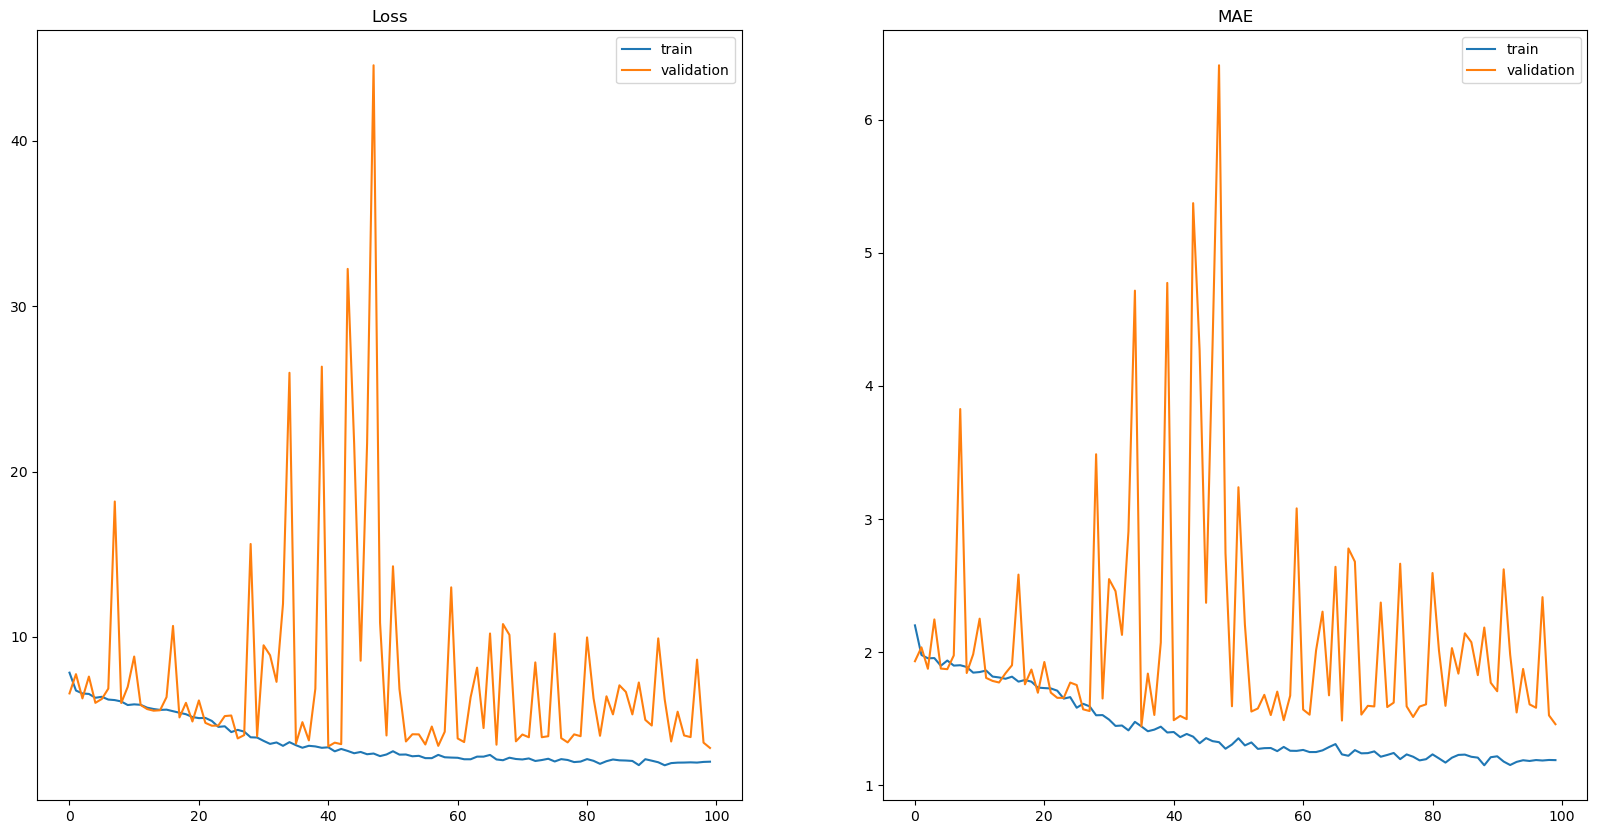

In [40]:
#plot loss and mae from training and validation data side by side
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.plot(model.history.history['loss'], label='train')
plt.plot(model.history.history['val_loss'], label='validation')
plt.title('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(model.history.history['mae'], label='train')
plt.plot(model.history.history['val_mae'], label='validation')
plt.title('MAE')
plt.legend()
plt.show()



